In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.interpolate import interp1d
import pandas as pd
import sncosmo
from scipy import stats
from scipy.special import expit
from nested_pandas import read_parquet
from joblib import Parallel, delayed

from tdastro.opsim.ztf_opsim import ZTFOpsim
from tdastro.astro_utils.passbands import PassbandGroup
from tdastro.astro_utils.pzflow_node import PZFlowNode
from tdastro.astro_utils.snia_utils import (
    DistModFromRedshift,
    HostmassX1Func,
    X0FromDistMod,
    num_snia_per_redshift_bin,
)
from tdastro.math_nodes.scipy_random import SamplePDF
from tdastro.math_nodes.np_random import NumpyRandomFunc
from tdastro.simulate import simulate_lightcurves
from tdastro.sources.sncomso_models import SncosmoWrapperModel
from tdastro.sources.snia_host import SNIaHost
from tdastro.utils.plotting import plot_lightcurves
from tdastro.math_nodes.ra_dec_sampler import OpSimUniformRADECSampler
from tdastro.astro_utils.dustmap import DustmapWrapper,SFDMap
from tdastro.effects.extinction import ExtinctionEffect
from tdastro.astro_utils.mag_flux import mag2flux,flux2mag

from tdastro import _TDASTRO_BASE_DATA_DIR

from tdastro.validation.lcfit import fit_single_lc

In [3]:
globalhostdata = pd.read_csv('ztfsniadr2/tables/globalhost_data.csv')
localhostdata = pd.read_csv('ztfsniadr2/tables/localhost_data.csv')
sndata = pd.read_csv('ztfsniadr2/tables/snia_data.csv')
data = pd.merge(sndata,globalhostdata,on='ztfname')

In [4]:
lcdata = read_parquet('data/ztfsniadr2.parquet')

In [5]:
%%time
# Load the OpSim data.
# opsim_db = ZTFOpsim.from_db("data/ztf_metadata_latest.db")

obs_log = pd.read_parquet('data/ztf_observing_log_combined_w_metadata.parquet')
colmap = {"ra":"ra",
          "dec":"dec",
          "time":"mjd",
          "zp":"zp_nJy",
          "filter":"filter",
          "sky":"scibckgnd",
         }
opsim_db = ZTFOpsim(obs_log,colmap=colmap)
opsim_db.radius = 3.868

t_min, t_max = opsim_db.time_bounds()
print(f"Loaded OpSim with {len(opsim_db)} rows and times [{t_min}, {t_max}]")

#Load the passband data for the griz filters only.
# passband_group = PassbandGroup(preset="LSST", filters_to_load=["g", "r", "i"], 
#                                units="nm", trim_quantile=0.001, delta_wave=1)
passband_group = PassbandGroup.from_preset(preset="ZTF", filters=["g", "r", "i"])
print(f"Loaded Passbands: {passband_group}")

2025-09-02 14:56:26,767 - INFO - Loading passbands from preset ZTF


Loaded OpSim with 522197 rows and times [58288.171875, 59273.55859375]
Loaded Passbands: PassbandGroup containing 3 passbands: ZTF_g, ZTF_r, ZTF_i
CPU times: user 423 ms, sys: 74.6 ms, total: 498 ms
Wall time: 527 ms


In [6]:
# Load the Flow model into a PZFlow node. This gives access to all of the outputs of the
# flow model as attributes of the PZFlowNode.
pz_node = PZFlowNode.from_file("data/ztfsniadr2_host_sn_before_selection_pzflow.pkl",  # filename
    node_label="pznode",
)
radec_node = OpSimUniformRADECSampler(opsim_db, radius=3.868, node_label="radec")

# Create a model for the host of the SNIa. The attributes will be sampled via
# the PZFlowNode's model. So each hos instantiation will have its own properties.
# Note: This requires the user to know the output names from the underlying flow model.

zmin = 0.001
zmax = 0.2
H0 = 70.0
Omega_m = 0.3
nsn, z = num_snia_per_redshift_bin(zmin, zmax, 100, H0=H0, Omega_m=Omega_m)
zpdf = interp1d(z, nsn, bounds_error=False, fill_value=0)

host = SNIaHost(
    ra = radec_node.ra,
    dec = radec_node.dec,
    hostmass=pz_node.mass,
    redshift=SamplePDF(zpdf),
    node_label="host",
)

INFO:2025-09-02 14:56:26,852:jax._src.xla_bridge:927: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-09-02 14:56:26,852 - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-09-02 14:56:26,855:jax._src.xla_bridge:927: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/mi/anaconda3/envs/tdastro/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
2025-09-02 14:56:26,855 - INFO - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Crypt

In [7]:
distmod_func = DistModFromRedshift(host.redshift, H0=73.0, Omega_m=0.3)
# x1_func = HostmassX1Func(host.hostmass)
# c_func = NumpyRandomFunc("normal", loc=0, scale=0.02)
m_abs_func = NumpyRandomFunc("normal", loc=-19., scale=0.1)
x0_func = X0FromDistMod(
    distmod=distmod_func,
    x1=pz_node.x1, #x1_func,
    c=pz_node.c, #c_func,
    alpha=0.14,
    beta=3.1,
    m_abs=m_abs_func,
    node_label="x0_func",
)

sncosmo_modelname = "salt3"
source = SncosmoWrapperModel(
    sncosmo_modelname,
    t0=NumpyRandomFunc("uniform", low=t_min, high=t_max),
    x0=x0_func,
    x1=pz_node.x1, #x1_func,
    c=pz_node.c, #c_func,
    ra=NumpyRandomFunc("normal", loc=host.ra, scale=0.01),
    dec=NumpyRandomFunc("normal", loc=host.dec, scale=0.01),
    redshift=host.redshift,
    node_label="source",
)
    
mwextinction = SFDMap(
    ra=source.ra,
    dec=source.dec,
    node_label="mwext",
)

# Create an extinction effect using the EBVs from that dust map.
ext_effect = ExtinctionEffect(extinction_model="F99", ebv=mwextinction, Rv=3.1)
source.add_effect(ext_effect)


2025-09-02 14:56:28,617 - INFO - SFD dust map data files not found.
Attempting to download from: ('https://github.com/kbarbary/sfddata/archive/master.tar.gz',)
to the directory /Users/mi/Work/tdastro/tdastro/data/dustmaps/sfdmap2


In [8]:
### Notes:
### ZTF SN Ia DR2 dates: March(April 1) 2018 - December (Dec 31) 2020
### ZTF has square field?
### Data release has 3628 SN Ia in total
### 2667 passed data quality cut
### volume-limited complete sample to z<0.06

In [9]:
%%time
nsntotal, _ = num_snia_per_redshift_bin(zmin, zmax, 1, H0=H0, Omega_m=Omega_m, solid_angle=9.136*3)
print(nsntotal)
lightcurves = simulate_lightcurves(source, int(nsntotal), opsim_db, passband_group)
lightcurves

[143093.63640252]


<timed exec>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


CPU times: user 17min 43s, sys: 4min 46s, total: 22min 30s
Wall time: 22min 32s


id          ra        dec  nobs         z  \
0            0  203.585880 -30.018263    14  0.184478   
1            1  152.220785 -20.698024     5  0.160279   
...        ...         ...        ...   ...       ...   
143091  143091  338.778072  14.850866   784  0.156203   
143092  143092  353.310931  54.948096  1450  0.172245   

                                                   params  \
0       {'radec.ra': 203.58440582652216, 'radec.dec': ...   
1       {'radec.ra': 152.2145259943807, 'radec.dec': -...   
...                                                   ...   
143091  {'radec.ra': 338.7765604878337, 'radec.dec': 1...   
143092  {'radec.ra': 353.3161675553079, 'radec.dec': 5...   

                                               lightcurve  
0       [{mjd: 59248.5, filter: 'g', flux: NaN, fluxer...  
1       [{mjd: 58449.515625, filter: 'r', flux: NaN, f...  
...                                                   ...  
143091  [{mjd: 58288.421875, filter: 'g', flux: 3341.1...  
143092  [{mjd: 58288.429688, filter: 'g', flux: 1358.9...  

[143093 rows x 7 columns]

In [10]:
lightcurves['params'][0].keys()

dict_keys(['radec.ra', 'radec.dec', 'host.ra', 'host.dec', 'host.redshift', 'host.t0', 'host.distance', 'host.hostmass', 'SamplePDF:_rvs_4.function_node_result', 'pznode.mass', 'pznode.x1', 'pznode.c', 'NumpyRandomFunc:normal_1.loc', 'NumpyRandomFunc:normal_1.scale', 'NumpyRandomFunc:normal_1.function_node_result', 'source.ra', 'source.dec', 'source.redshift', 'source.t0', 'source.distance', 'source.x0', 'source.x1', 'source.c', 'source.Rv', 'source.ebv', 'NumpyRandomFunc:normal_6.loc', 'NumpyRandomFunc:normal_6.scale', 'NumpyRandomFunc:normal_6.function_node_result', 'NumpyRandomFunc:uniform_7.low', 'NumpyRandomFunc:uniform_7.high', 'NumpyRandomFunc:uniform_7.function_node_result', 'DistModFromRedshift:_distmod_from_redshift_9.redshift', 'DistModFromRedshift:_distmod_from_redshift_9.function_node_result', 'x0_func.distmod', 'x0_func.x1', 'x0_func.c', 'x0_func.alpha', 'x0_func.beta', 'x0_func.m_abs', 'x0_func.function_node_result', 'NumpyRandomFunc:normal_10.loc', 'NumpyRandomFunc:norm

In [11]:
lightcurves.lightcurve.isna().sum()

15

In [12]:
#apply detection and spec efficiency
lightcurves = lightcurves.dropna(subset=['lightcurve'])
print("Before applying detection: nsn=", len(lightcurves))
lightcurves['lightcurve.snr'] = lightcurves['lightcurve.flux']/lightcurves['lightcurve.fluxerr']
lightcurves_after_detection = lightcurves.query('lightcurve.snr > 5').dropna(subset=['lightcurve'])
print("After applying detection: nsn=", len(lightcurves_after_detection))
# # simple selection function requiring max mag < 18.5
# maglim = mag2flux(18.5)
# idx = lightcurves_after_detection.query(f'lightcurve.flux > {maglim}').dropna(subset=['lightcurve']).index
# lightcurves_after_spec_selection = lightcurves_after_detection.loc[idx]
# print("After spectroscopic selection: nsn=", len(lightcurves_after_spec_selection))

Before applying detection: nsn= 143078


/Users/mi/anaconda3/envs/tdastro/lib/python3.11/site-packages/nested_pandas/nestedframe/core.py:407: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().__setitem__(nested, new_nested_series)
/Users/mi/anaconda3/envs/tdastro/lib/python3.11/site-packages/nested_pandas/nestedframe/core.py:645: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  answer = super().eval(expr, **kwargs)


After applying detection: nsn= 82379


ZTF Selection Function (Fig 4 of ZTF DR2 Overview paper https://arxiv.org/pdf/2409.04346)
<img src="figs/ztf_selection_function.png" width="800" height="400">
<img src="figs/ztf_selection_function_formulism.png" width="800" height="400">

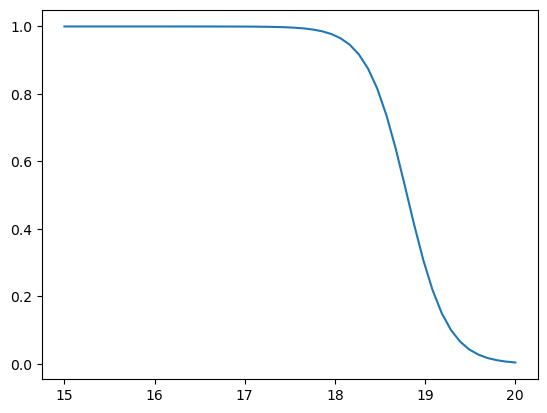

In [13]:
m = np.linspace(15,20,50)
m0=18.8
s=4.5
p = np.power(1. + np.exp((m - m0)*s), -1)
plt.plot(m,p)

In [14]:
# implement the the above selection function

def spec_selection_func(flux,m0=18.8,s=4.5):
    m = flux2mag(np.max(flux))
    p = np.power(1. + np.exp((m - m0)*s), -1)
    p0 = np.random.uniform(0,1)
    if p0 < p:
        return {"pass_spec_selection":1}
    else:
        return {"pass_spec_selection":0}

pass_selection = lightcurves_after_detection.reduce(spec_selection_func,"lightcurve.flux")
idx = pass_selection.query("pass_spec_selection == 1").index
lightcurves_after_spec_selection = lightcurves_after_detection.loc[idx]
print("After spectroscopic selection: nsn=", len(lightcurves_after_spec_selection))

After spectroscopic selection: nsn= 5825


In [15]:
#apply some data quality cut for fitting
lightcurves_after_nobs_cut = lightcurves_after_spec_selection[np.array(lightcurves_after_spec_selection.reduce(len, "lightcurve.mjd") > 7)]
print("After nobs cut: nsn=", len(lightcurves_after_nobs_cut))

After nobs cut: nsn= 5438


In [16]:
## ZTF SN DR2 selection cuts
# Start 3795
# No ZTF light curve -17 = 3778
# No spectra -110 = 3668
# No confirmed Ia type from spectra -40 = 3628
# Good sampling (7 different phases, 2 before, 2 after peak, 2 bands) = 2960
# SALT2 cuts = 2667

#### ZTF SN DR2 selection cuts
<img src="figs/ztf_selection_Table1_Rigault2024.png" width="800" height="400">

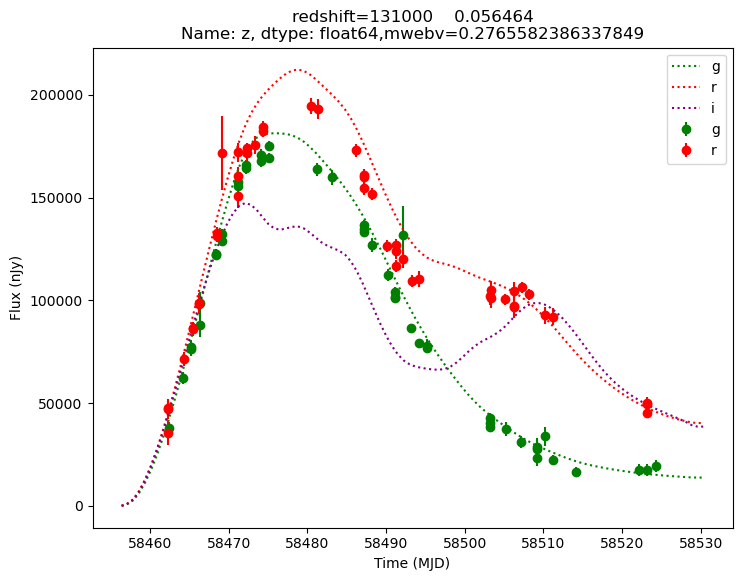

In [17]:
random_ids = lightcurves_after_nobs_cut.id.sample(1).values
colormap = {'g':'g',
            'r':'r',
            'i':'purple',}

for random_id in random_ids:
    # Extract the row for this object.
    lc = lightcurves.loc[lightcurves.id==random_id]
    lc = lightcurves_after_nobs_cut.loc[lightcurves_after_nobs_cut.id==random_id]
    
    if lc["nobs"].values[0] > 0:
        # Unpack the nested columns (filters, mjd, flux, and flux error).
        lc_filters = np.asarray(lc["lightcurve.filter"], dtype=str)
        lc_mjd = np.asarray(lc["lightcurve.mjd"], dtype=float)
        lc_flux = np.asarray(lc["lightcurve.flux"], dtype=float)
        lc_fluxerr = np.asarray(lc["lightcurve.fluxerr"], dtype=float)

        lc_mag = -2.5*np.log10(lc_flux) + 31.4
        lc_magerr = np.absolute(1.086*lc_fluxerr/lc_flux)
        
        plot_lightcurves(
            fluxes=lc_flux,
            times=lc_mjd,
            fluxerrs=lc_fluxerr,
            filters=lc_filters,
            colormap=colormap,
        )
        plt.ylabel('Flux (nJy)')
        plt.title(f"redshift={lc['z']},mwebv={lc['params'].values[0]['mwext.ebv']}")

        model = sncosmo.Model(source=sncosmo_modelname,
                      effects=[sncosmo.F99Dust()],
                      effect_names=['mw'],
                      effect_frames=['obs'])
        pardict = {}
        for p in ['x0','x1','c','t0']:
            pardict[p] = lc['params'].values[0][f'source.{p}']
        pardict['mwebv'] = lc['params'].values[0]['mwext.ebv']
        pardict['z'] = lc['z'].values[0]
        model.update(pardict)
        t = np.linspace(-20,50,100)
        obstime = t*(1+pardict['z'])+pardict['t0']
        for b in 'gri':
            plt.plot(obstime,model.bandflux('lsst'+b,obstime,zp=31.4,zpsys='ab'),label=b,ls=':',color=colormap[b])
        plt.legend()
        plt.show()

        # plot_lightcurves(
        #     fluxes=lc_mag,
        #     times=lc_mjd,
        #     fluxerrs=lc_magerr,
        #     filters=lc_filters,
        # )
        # plt.ylabel('Mag')
        # plt.ylim(plt.ylim()[::-1])
        plt.show()

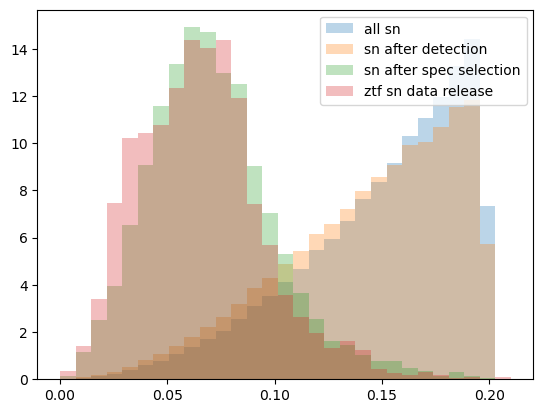

<Figure size 640x480 with 0 Axes>

In [18]:
bins=np.linspace(0,0.21,30)
plt.hist(lightcurves['z'],bins=bins,alpha=0.3,density=True,label='all sn')
plt.hist(lightcurves_after_detection['z'],bins=bins,alpha=0.3,density=True,label='sn after detection')
plt.hist(lightcurves_after_spec_selection['z'],bins=bins,alpha=0.3,density=True,label='sn after spec selection')
plt.hist(data.redshift,bins=bins,alpha=0.3,density=True,label='ztf sn data release')
plt.legend()
plt.show()
plt.savefig('paper_figs/z_distr.png')

In [19]:
# data quality flags

# from https://github.com/ZwickyTransientFacility/ztfcosmo/blob/260e136be064708e1238719880ce18844027422e/ztfcosmo/lightcurve.py#L111
# flagout: [list of int or string]
#     flag == 0 means all good, but in details:
    
#     0: no warning 
#     1: flux_err==0 Remove unphysical errors 
#     2: chi2dof>3: Remove extreme outliers 
#     4: cloudy>1: BTS cut 
#     8: infobits>0: BTS cut 16: mag_lim<19.3: Cut applied in Dhawan 2021 
#     32: seeing>3: Cut applied in Dhawan 2021 
#     64: fieldid>879: Recommended IPAC cut 
#     128: moonilf>0.5: Recommended IPAC cut 
#     256: has_baseline>1: Has a valid baseline correction 
#     512: airmass>2: Recommended IPAC cut 
#     1024: flux/flux_err>=5: Nominal detection

/Users/mi/anaconda3/envs/tdastro/lib/python3.11/site-packages/nested_pandas/nestedframe/core.py:645: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  answer = super().eval(expr, **kwargs)


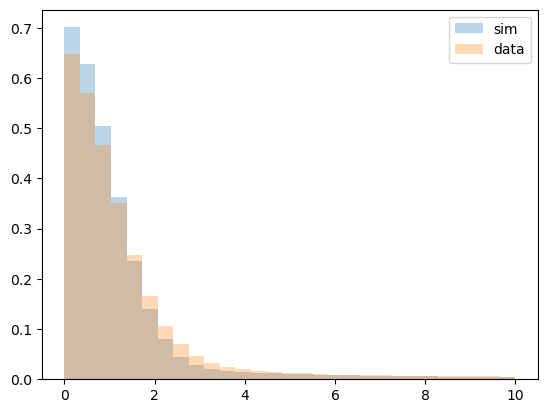

In [20]:
lc_to_plot = lightcurves.loc[lightcurves_after_detection.index]
bins = np.linspace(0,10,30)
plt.hist(lc_to_plot['lightcurve.snr'],bins=bins,alpha=0.3,density=True,label='sim')
lcdata_plot = lcdata.query('lc.flag == 1024 or lc.flag == 0').dropna(subset='lc')
lcdata_plot['lc.snr'] = lcdata_plot['lc.flux']/lcdata_plot['lc.flux_err']
plt.hist(lcdata_plot['lc.snr'],bins=bins,alpha=0.3,density=True,label='data')
plt.legend()
plt.show()

/Users/mi/anaconda3/envs/tdastro/lib/python3.11/site-packages/nested_pandas/nestedframe/core.py:645: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  answer = super().eval(expr, **kwargs)
/Users/mi/anaconda3/envs/tdastro/lib/python3.11/site-packages/nested_pandas/nestedframe/core.py:645: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  answer = super().eval(expr, **kwargs)


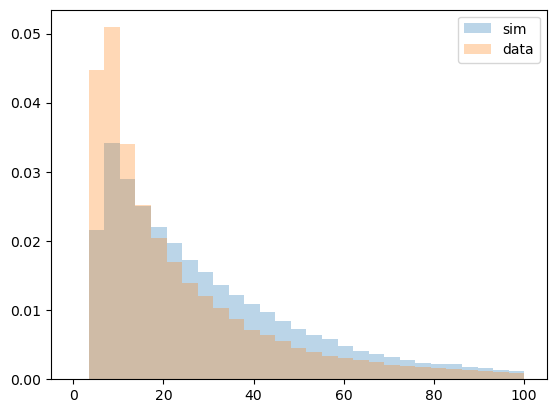

In [21]:
lc_to_plot = lightcurves_after_detection.loc[lightcurves_after_spec_selection.index]
bins = np.linspace(0,100,30)
plt.hist(lc_to_plot['lightcurve.snr'],bins=bins,alpha=0.3,density=True,label='sim')
lcdata_plot = lcdata.query('lc.flag == 1024 or lc.flag == 0').dropna(subset='lc')
lcdata_plot['lc.snr'] = lcdata_plot['lc.flux']/lcdata_plot['lc.flux_err']
lcdata_plot = lcdata_plot.query('lc.snr > 5').dropna(subset='lc')
plt.hist(lcdata_plot['lc.snr'],bins=bins,alpha=0.3,density=True,label='data')
plt.legend()
plt.show()

/Users/mi/anaconda3/envs/tdastro/lib/python3.11/site-packages/nested_pandas/nestedframe/core.py:645: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  answer = super().eval(expr, **kwargs)
/Users/mi/anaconda3/envs/tdastro/lib/python3.11/site-packages/nested_pandas/nestedframe/core.py:645: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  answer = super().eval(expr, **kwargs)


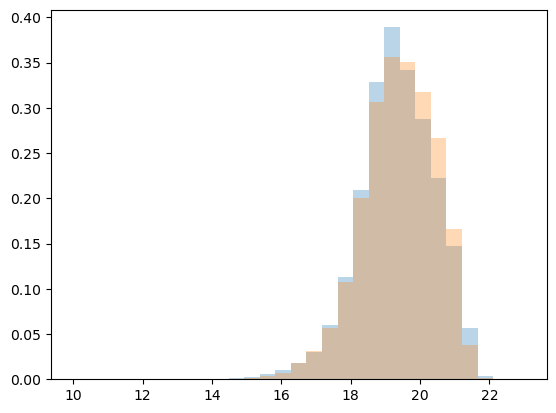

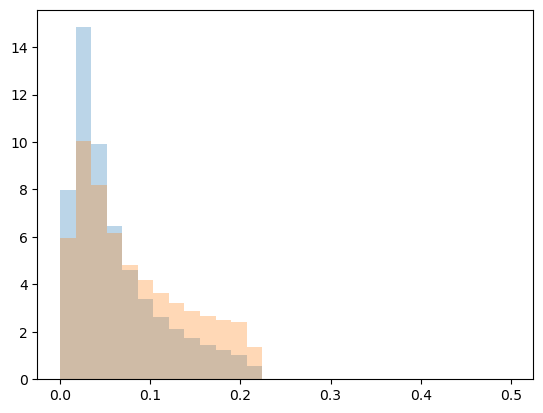

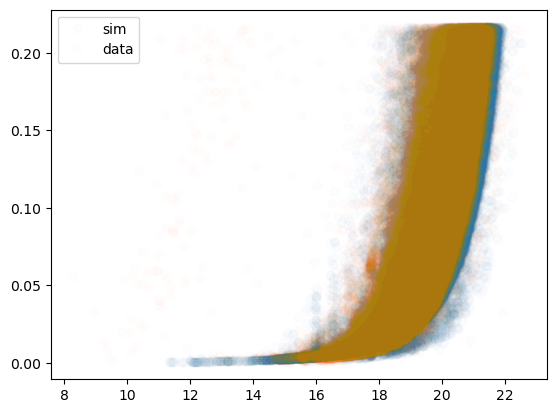

In [22]:
def convert_flux_to_mag(flux,fluxerr,zp=0.):
    mag = -2.5*np.log10(flux) + zp
    magerr = 2.5/np.log(10.)*fluxerr/flux
    return mag,magerr

lc_to_plot = lightcurves_after_detection.loc[lightcurves_after_spec_selection.index]
bins = np.linspace(10,23,30)
lcdata_plot = lcdata.query('lc.flag == 1024 or lc.flag == 0').dropna(subset='lc')
lcdata_plot['lc.snr'] = lcdata_plot['lc.flux']/lcdata_plot['lc.flux_err']
lcdata_plot = lcdata_plot.query('lc.snr > 5').dropna(subset='lc')
lcdata_mag,lcdata_magerr = convert_flux_to_mag(lcdata_plot['lc.flux'],lcdata_plot['lc.flux_err'],zp=30.)
lc_to_plot_mag,lc_to_plot_magerr = convert_flux_to_mag(lc_to_plot['lightcurve.flux'],lc_to_plot['lightcurve.fluxerr'],zp=31.4)
plt.hist(lc_to_plot_mag,bins=bins,alpha=0.3,density=True)
plt.hist(lcdata_mag,bins=bins,alpha=0.3,density=True)
plt.show()
bins = np.linspace(0,0.5,30)
plt.hist(lc_to_plot_magerr,bins=bins,alpha=0.3,density=True)
plt.hist(lcdata_magerr,bins=bins,alpha=0.3,density=True)
plt.show()
plt.plot(lc_to_plot_mag,lc_to_plot_magerr,'o',alpha=0.01,label='sim')
plt.plot(lcdata_mag,lcdata_magerr,'o',alpha=0.01,label='data')
plt.legend()
plt.show()

/Users/mi/anaconda3/envs/tdastro/lib/python3.11/site-packages/nested_pandas/nestedframe/core.py:645: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  answer = super().eval(expr, **kwargs)


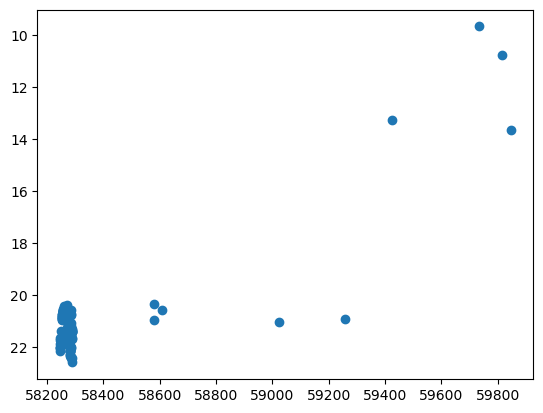

ZTF18aashtth
             mjd filter          flux      flux_err    ZP  flag       mag  \
0    58246.33757   ztfg  5.008439e+03  8.449795e+02  30.0  1024  20.75074   
1    58246.36031   ztfg  5.797578e+03  7.928762e+02  30.0  1024  20.59188   
..           ...    ...           ...           ...   ...   ...       ...   
137  59816.20694   ztfg  1.796189e+08  1.232231e+06  30.0  1024   9.36412   
138  59847.16666   ztfg  1.267507e+07  1.602516e+06  30.0  1024  12.24262   

     mag_err  field_id  rcid  flux_offset  offset_unc  err_scale  in_baseline  \
0    0.18318       635  32.0    167.23896    43.98385        1.0            0   
1    0.14849       635  32.0    167.23896    43.98385        1.0            0   
..       ...       ...   ...          ...         ...        ...          ...   
137  0.00745       635  32.0    167.23896    43.98385        1.0            0   
138  0.13727       635  32.0    167.23896    43.98385        1.0            0   

            snr  
0      5.927291  
1

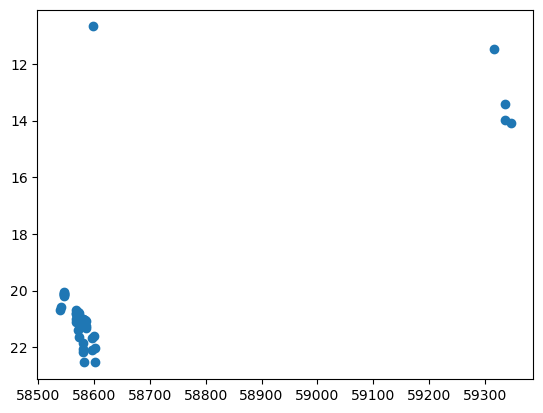

ZTF19aaksrgj
            mjd filter          flux      flux_err    ZP  flag       mag  \
0   58539.35573   ztfr  1.921365e+04  1.685139e+03  30.0  1024  19.29098   
1   58540.35671   ztfg  2.152612e+04  7.051787e+02  30.0  1024  19.16759   
..          ...    ...           ...           ...   ...   ...       ...   
40  59335.23204   ztfg  9.258658e+06  1.584806e+06  30.0  1024  12.58363   
41  59346.31597   ztfg  8.449574e+06  1.602285e+06  30.0  1024  12.68291   

    mag_err  field_id  rcid  flux_offset  offset_unc  err_scale  in_baseline  \
0   0.09522       474  60.0   1029.44408   139.55419        1.0            0   
1   0.03557       525   2.0     22.28824    62.57741        1.0            0   
..      ...       ...   ...          ...         ...        ...          ...   
40  0.18585       525   2.0     22.28824    62.57741        1.0            0   
41  0.20589       525   2.0     22.28824    62.57741        1.0            0   

          snr  
0   11.401815  
1   30.525769  
.

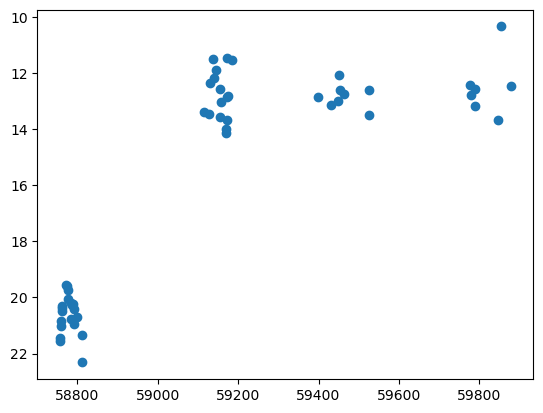

ZTF19accmxtw
            mjd filter          flux      flux_err    ZP  flag       mag  \
0   58757.26645   ztfi  9.443234e+03  1.312251e+03  30.0  1024  20.06220   
1   58758.21080   ztfg  8.818193e+03  6.746138e+02  30.0  1024  20.13655   
..          ...    ...           ...           ...   ...   ...       ...   
49  59854.30641   ztfr  2.638430e+08  7.961178e+06  30.0  1024   8.94664   
50  59878.13013   ztfr  3.765777e+07  1.394651e+06  30.0  1024  11.06036   

    mag_err  field_id  rcid  flux_offset  offset_unc  err_scale  in_baseline  \
0   0.15088       597  29.0   -326.73539   225.93636    1.19402            0   
1   0.08306       597  29.0     81.34453    53.43814    1.00000            0   
..      ...       ...   ...          ...         ...        ...          ...   
49  0.03276       597  29.0   -406.89933    81.82750    1.16814            0   
50  0.04021       597  29.0   -406.89933    81.82750    1.16814            0   

          snr  
0    7.196210  
1   13.071468  
.

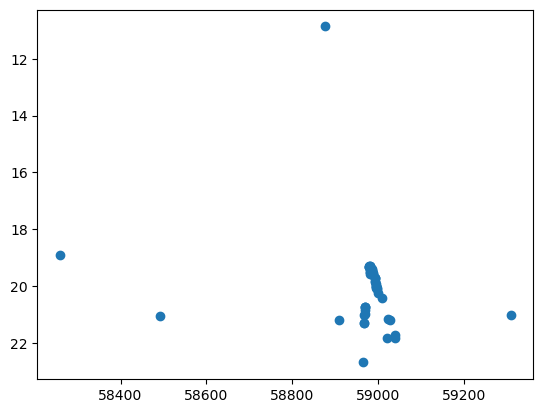

ZTF20aaxahpk
            mjd filter         flux     flux_err    ZP  flag       mag  \
0   58259.17374   ztfg  98462.52214  19616.43048  30.0  1024  17.51682   
1   58492.48949   ztfr  13727.88280   2446.91805  30.0  1024  19.65599   
..          ...    ...          ...          ...   ...   ...       ...   
46  59038.17892   ztfr   7387.45796   1025.23483  30.0  1024  20.32876   
47  59308.34090   ztfg  14125.28312   2308.68883  30.0  1024  19.62501   

    mag_err  field_id  rcid  flux_offset  offset_unc  err_scale  in_baseline  \
0   0.21631       713  33.0    255.41977   122.83969    1.03982            0   
1   0.19353       713  33.0   -128.40675    56.83178    1.04531            0   
..      ...       ...   ...          ...         ...        ...          ...   
46  0.15068       713  33.0   -128.40675    56.83178    1.04531            0   
47  0.17746       713  33.0    255.41977   122.83969    1.03982            0   

         snr  
0   5.019390  
1   5.610275  
..       ...  
4

In [23]:
# check about the outliers in data
maglim = mag2flux(11)
idx = lcdata_plot.query(f'lc.flux > {maglim}').dropna(subset='lc').index
outlier = lcdata_plot.loc[idx]
for i in range(0,np.min([10,len(outlier)])):
    plt.plot(outlier.iloc[i]['lc']['mjd'],flux2mag(outlier.iloc[i]['lc']['flux']),'o')
    plt.ylim(plt.ylim()[::-1])
    plt.show()
    print(outlier.iloc[i]['ztfname'])
    print(outlier.iloc[i]['lc'])

/Users/mi/anaconda3/envs/tdastro/lib/python3.11/site-packages/nested_pandas/nestedframe/core.py:645: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  answer = super().eval(expr, **kwargs)
/Users/mi/anaconda3/envs/tdastro/lib/python3.11/site-packages/nested_pandas/nestedframe/core.py:645: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  answer = super().eval(expr, **kwargs)


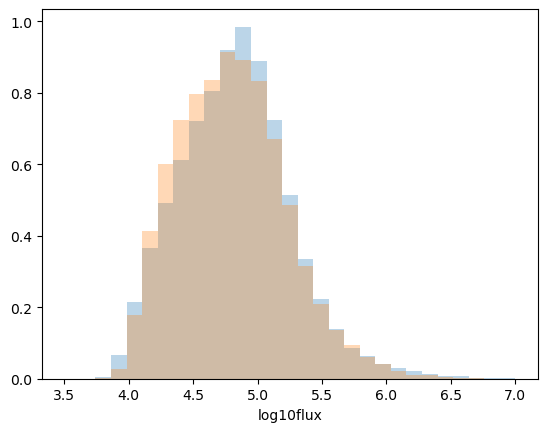

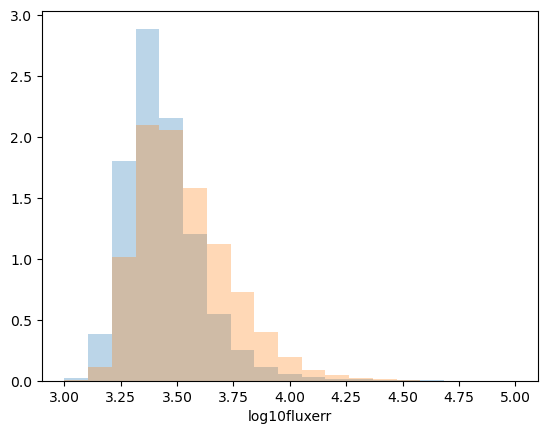

/var/folders/zs/zxl3t6ks12zg2l3dp9qn1rkr0000gn/T/ipykernel_37726/4094580003.py:43: UserWarning: The following kwargs were not used by contour: 'label'
  CS = plt.contour(lcsim_x_plot.T,lcsim_y_plot.T,lcsim_count,alpha=0.5,label='sim',levels=10,colors='C0')
/var/folders/zs/zxl3t6ks12zg2l3dp9qn1rkr0000gn/T/ipykernel_37726/4094580003.py:44: UserWarning: The following kwargs were not used by contour: 'label'
  CS = plt.contour(lcdata_x_plot.T,lcdata_y_plot.T,lcdata_count,alpha=0.5,label='data',levels=10,colors='C1')


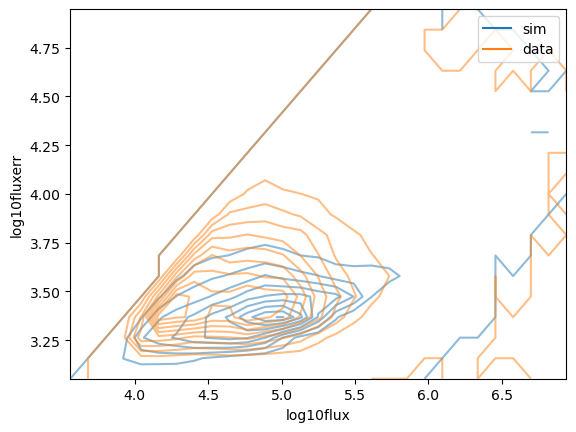

In [24]:
def convert_flux_to_njy(flux,fluxerr,zp=0.):
    zp_njy = 31.4
    #-2.5*log10(flux_njy) + zp_njy = -2.5*log10(flux) + zp
    flux_njy = flux*np.power(10., -0.4*(zp-zp_njy))
    fluxerr_njy = fluxerr*np.power(10., -0.4*(zp-zp_njy))         
    return flux_njy,fluxerr_njy

lc_to_plot = lightcurves_after_detection.loc[lightcurves_after_spec_selection.index]
lcdata_plot = lcdata.query('lc.flag == 1024 or lc.flag == 0').dropna(subset='lc')
lcdata_plot['lc.snr'] = lcdata_plot['lc.flux']/lcdata_plot['lc.flux_err']
lcdata_plot = lcdata_plot.query('lc.snr > 5').dropna(subset='lc')
lcdata_flux_njy,lcdata_fluxerr_njy = convert_flux_to_njy(lcdata_plot['lc.flux'],lcdata_plot['lc.flux_err'],zp=30.)

lcdata_logflux = np.log10(lcdata_flux_njy)
lcdata_logfluxerr = np.log10(lcdata_fluxerr_njy)
lcsim_logflux = np.log10(lc_to_plot['lightcurve.flux'])
lcsim_logfluxerr = np.log10(lc_to_plot['lightcurve.fluxerr'])
logbins_flux = np.linspace(3.5,7,30)
logbins_fluxerr = np.linspace(3,5,20)

plt.hist(lcsim_logflux,bins=logbins_flux,alpha=0.3,density=True)
plt.hist(lcdata_logflux,bins=logbins_flux,alpha=0.3,density=True)
plt.xlabel("log10flux")
plt.show()

plt.hist(lcsim_logfluxerr,bins=logbins_fluxerr,alpha=0.3,density=True)
plt.hist(lcdata_logfluxerr,bins=logbins_fluxerr,alpha=0.3,density=True)
plt.xlabel("log10fluxerr")
plt.show()

lcsim_count,lcsim_x_edges,lcsim_y_edges, _ = stats.binned_statistic_2d(lcsim_logflux,lcsim_logfluxerr,
                                             np.ones(len(lcsim_logflux)),
                                             statistic='sum',bins=[logbins_flux,logbins_fluxerr])
lcdata_count,lcdata_x_edges,lcdata_y_edges,_ = stats.binned_statistic_2d(lcdata_logflux,lcdata_logfluxerr,
                                         np.ones(len(lcdata_logflux)),
                                         statistic='sum',bins=[logbins_flux,logbins_fluxerr])
lcsim_x = 0.5* (lcsim_x_edges[:-1]+lcsim_x_edges[1:])
lcsim_y = 0.5* (lcsim_y_edges[:-1]+lcsim_y_edges[1:])
lcdata_x = 0.5* (lcdata_x_edges[:-1]+lcdata_x_edges[1:])
lcdata_y = 0.5* (lcdata_y_edges[:-1]+lcdata_y_edges[1:])
lcsim_x_plot,lcsim_y_plot = np.meshgrid(lcsim_x, lcsim_y)
lcdata_x_plot,lcdata_y_plot = np.meshgrid(lcdata_x, lcdata_y)
CS = plt.contour(lcsim_x_plot.T,lcsim_y_plot.T,lcsim_count,alpha=0.5,label='sim',levels=10,colors='C0')
CS = plt.contour(lcdata_x_plot.T,lcdata_y_plot.T,lcdata_count,alpha=0.5,label='data',levels=10,colors='C1')
proxies = [Line2D([],[],color=c) for c in ['C0','C1']]
plt.legend(proxies,['sim', 'data'])
plt.xlabel('log10flux')
plt.ylabel('log10fluxerr')
plt.show()

In [25]:
np.shape(lcsim_x), np.shape(lcsim_y),np.shape(lcsim_x_plot),np.shape(lcsim_y_plot)

((29,), (19,), (19, 29), (19, 29))

/Users/mi/anaconda3/envs/tdastro/lib/python3.11/site-packages/nested_pandas/nestedframe/core.py:645: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  answer = super().eval(expr, **kwargs)
/Users/mi/anaconda3/envs/tdastro/lib/python3.11/site-packages/nested_pandas/nestedframe/core.py:645: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  answer = super().eval(expr, **kwargs)


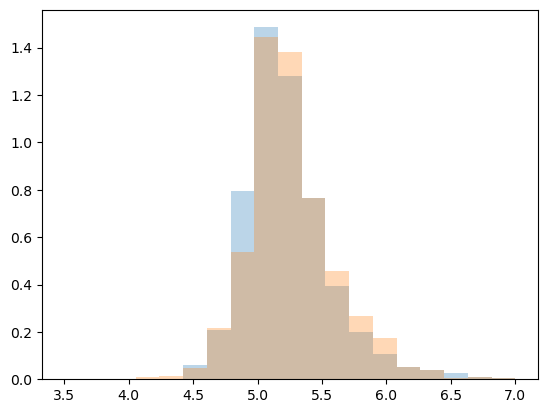

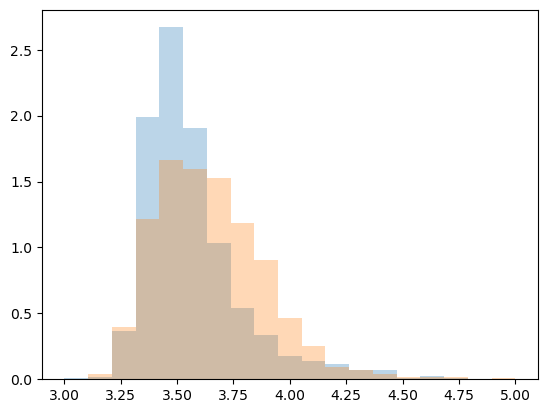

/var/folders/zs/zxl3t6ks12zg2l3dp9qn1rkr0000gn/T/ipykernel_37726/2052247313.py:43: UserWarning: The following kwargs were not used by contour: 'label'
  CS = plt.contour(lcsim_x_plot.T,lcsim_y_plot.T,lcsim_count,alpha=0.5,label='sim',levels=10,colors='C0')
/var/folders/zs/zxl3t6ks12zg2l3dp9qn1rkr0000gn/T/ipykernel_37726/2052247313.py:44: UserWarning: The following kwargs were not used by contour: 'label'
  CS = plt.contour(lcdata_x_plot.T,lcdata_y_plot.T,lcdata_count,alpha=0.5,label='data',levels=10,colors='C1')


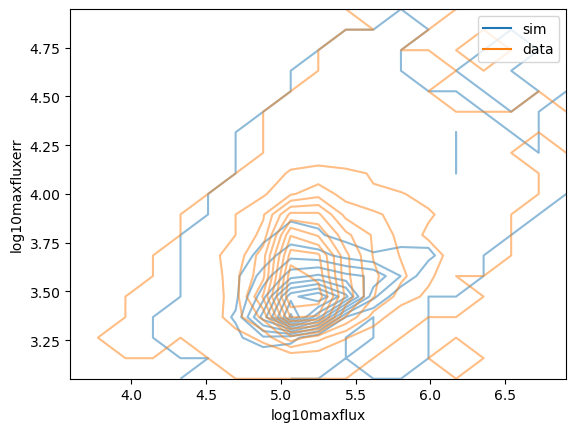

In [26]:
lc_to_plot = lightcurves_after_detection.loc[lightcurves_after_spec_selection.index]
lcdata_plot = lcdata.query('lc.flag == 1024 or lc.flag == 0').dropna(subset='lc')
lcdata_plot['lc.snr'] = lcdata_plot['lc.flux']/lcdata_plot['lc.flux_err']
lcdata_plot = lcdata_plot.query('lc.snr > 5').dropna(subset='lc')
def get_maxflux_and_err(flux,fluxerr):
    idx = np.argmax(flux)
    maxflux = flux[idx]
    maxfluxerr = fluxerr[idx]
    return {"maxflux":maxflux,"maxfluxerr":maxfluxerr}
lcdata_maxflux = lcdata_plot.reduce(get_maxflux_and_err,"lc.flux","lc.flux_err")
lcdata_maxflux_njy,lcdata_maxfluxerr_njy = convert_flux_to_njy(lcdata_maxflux["maxflux"],lcdata_maxflux["maxfluxerr"],
                                                               zp=30.)

lcdata_logmaxflux = np.log10(lcdata_maxflux_njy)
lcdata_logmaxfluxerr = np.log10(lcdata_maxfluxerr_njy)

lcsim_maxflux = lc_to_plot.reduce(get_maxflux_and_err,"lightcurve.flux","lightcurve.fluxerr")
lcsim_logmaxflux = np.log10(lcsim_maxflux["maxflux"])
lcsim_logmaxfluxerr = np.log10(lcsim_maxflux["maxfluxerr"])
logbins_flux = np.linspace(3.5,7,20)
logbins_fluxerr = np.linspace(3,5,20)

plt.hist(lcsim_logmaxflux,bins=logbins_flux,alpha=0.3,density=True)
plt.hist(lcdata_logmaxflux,bins=logbins_flux,alpha=0.3,density=True)
plt.show()

plt.hist(lcsim_logmaxfluxerr,bins=logbins_fluxerr,alpha=0.3,density=True)
plt.hist(lcdata_logmaxfluxerr,bins=logbins_fluxerr,alpha=0.3,density=True)
plt.show()

lcsim_count,lcsim_x_edges,lcsim_y_edges, _ = stats.binned_statistic_2d(lcsim_logmaxflux,lcsim_logmaxfluxerr,
                                             np.ones(len(lcsim_logmaxflux)),
                                             statistic='sum',bins=[logbins_flux,logbins_fluxerr])
lcdata_count,lcdata_x_edges,lcdata_y_edges,_ = stats.binned_statistic_2d(lcdata_logmaxflux,lcdata_logmaxfluxerr,
                                         np.ones(len(lcdata_logmaxflux)),
                                         statistic='sum',bins=[logbins_flux,logbins_fluxerr])
lcsim_x = 0.5* (lcsim_x_edges[:-1]+lcsim_x_edges[1:])
lcsim_y = 0.5* (lcsim_y_edges[:-1]+lcsim_y_edges[1:])
lcdata_x = 0.5* (lcdata_x_edges[:-1]+lcdata_x_edges[1:])
lcdata_y = 0.5* (lcdata_y_edges[:-1]+lcdata_y_edges[1:])
lcsim_x_plot,lcsim_y_plot = np.meshgrid(lcsim_x, lcsim_y)
lcdata_x_plot,lcdata_y_plot = np.meshgrid(lcdata_x, lcdata_y)
CS = plt.contour(lcsim_x_plot.T,lcsim_y_plot.T,lcsim_count,alpha=0.5,label='sim',levels=10,colors='C0')
CS = plt.contour(lcdata_x_plot.T,lcdata_y_plot.T,lcdata_count,alpha=0.5,label='data',levels=10,colors='C1')
proxies = [Line2D([],[],color=c) for c in ['C0','C1']]
plt.legend(proxies,['sim', 'data'])
plt.xlabel('log10maxflux')
plt.ylabel('log10maxfluxerr')
plt.show()

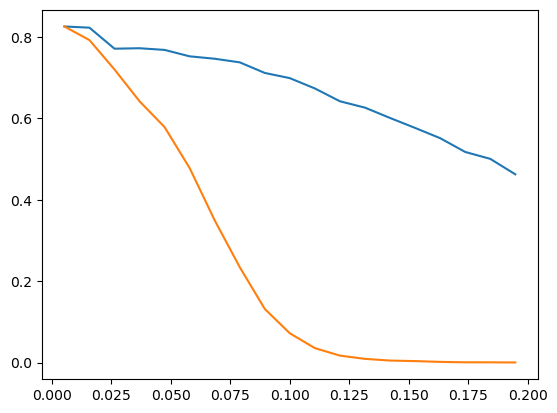

In [27]:
bins = np.linspace(0,0.2,20)
zbefore,bin_edges,_ = stats.binned_statistic(lightcurves['z'],np.ones(len(lightcurves)), statistic='sum', bins=bins)
zafter,bin_edges,_ =  stats.binned_statistic(lightcurves_after_detection['z'], np.ones(len(lightcurves_after_detection)), statistic='sum', bins=bins)
zafter_spec,bin_edges,_ =  stats.binned_statistic(lightcurves_after_spec_selection['z'], np.ones(len(lightcurves_after_spec_selection)), statistic='sum', bins=bins)
plt.plot((bin_edges[:-1] + bin_edges[1:])/2.,zafter/zbefore)
plt.plot((bin_edges[:-1] + bin_edges[1:])/2.,zafter_spec/zbefore)

In [28]:
sim_all_x1 = [lightcurves.loc[i]['params']['source.x1'] for i in lightcurves.index]
sim_all_c = [lightcurves.loc[i]['params']['source.c'] for i in lightcurves.index]

In [29]:
sim_x1 = [lightcurves_after_nobs_cut.loc[i]['params']['source.x1'] for i in lightcurves_after_nobs_cut.index]
sim_c = [lightcurves_after_nobs_cut.loc[i]['params']['source.c'] for i in lightcurves_after_nobs_cut.index]

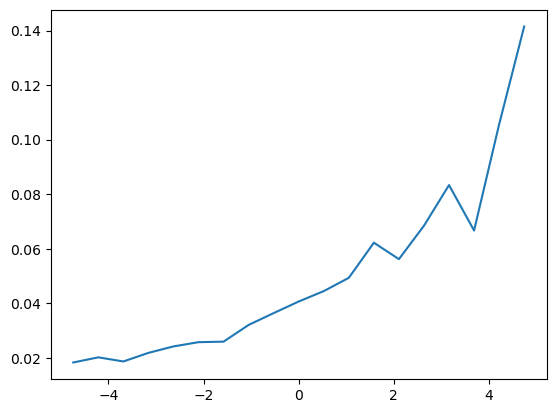

In [30]:
bins = np.linspace(-5,5,20)
x1before,bin_edges,_ = stats.binned_statistic(sim_all_x1,np.ones(len(lightcurves)), statistic='sum', bins=bins)
x1after,bin_edges,_ =  stats.binned_statistic(sim_x1, np.ones(len(lightcurves_after_nobs_cut)), statistic='sum', bins=bins)
plt.plot((bin_edges[:-1] + bin_edges[1:])/2.,x1after/x1before)
plt.savefig('paper_figs/x1_selection.png')

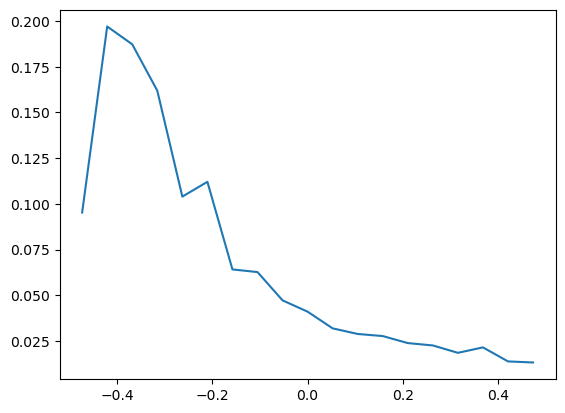

In [31]:
bins = np.linspace(-0.5,0.5,20)
cbefore,bin_edges,_ = stats.binned_statistic(sim_all_c,np.ones(len(lightcurves)), statistic='sum', bins=bins)
cafter,bin_edges,_ =  stats.binned_statistic(sim_c, np.ones(len(lightcurves_after_nobs_cut)), statistic='sum', bins=bins)
plt.plot((bin_edges[:-1] + bin_edges[1:])/2.,cafter/cbefore)
plt.savefig('paper_figs/c_selection.png')

In [32]:
res = fit_single_lc(lightcurves.loc[0])
res

2025-09-02 15:21:38,316 - INFO - fitting 0, z=0.18447834777715547, mwebv=0.04459043636746597.


id    0
dtype: int64

In [33]:
lc_to_fit = lightcurves_after_nobs_cut.iloc[0:]

In [34]:
# %%time
# result_df0 = lc_to_fit.apply(fit_single_lc,axis=1)

In [35]:
%%time
results = Parallel(n_jobs=10)(delayed(fit_single_lc)(row) for _index, row in lc_to_fit.iterrows())
result_df = pd.DataFrame(results)

/Users/mi/anaconda3/envs/tdastro/lib/python3.11/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/Users/mi/anaconda3/envs/tdastro/lib/python3.11/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/Users/mi/anaconda3/envs/tdastro/lib/python3.11/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/Users/mi/anaconda3/envs/tdastro/lib/python3.11/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/Users/mi/anaconda3/envs/tdastro/lib/p

CPU times: user 9.51 s, sys: 2.07 s, total: 11.6 s
Wall time: 1min 42s


In [36]:
result_df = result_df.set_index('id')

In [37]:
result_df.dropna()

,success,ncall,chisq,ndof,z,z_err,t0,t0_err,x0,x0_err,...,c_x0_cov,c_x1_cov,c_c_cov,c_mwebv_cov,mwebv_z_cov,mwebv_t0_cov,mwebv_x0_cov,mwebv_x1_cov,mwebv_c_cov,mwebv_mwebv_cov
id,,,,,,,,,,,,,,,,,,,,,
15.0,1.0,104.0,73.756334,76.0,0.045969,0.0,58805.032835,0.042164,0.002075,0.000012,...,-3.976865e-08,2.589499e-05,0.000017,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32.0,1.0,119.0,150.942189,161.0,0.043383,0.0,58848.461531,0.040838,0.000972,0.000004,...,-1.383522e-08,1.745174e-07,0.000013,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143001.0,1.0,82.0,46.067048,49.0,0.053166,0.0,58383.502605,0.096523,0.001473,0.000013,...,-8.394181e-08,2.990458e-04,0.000066,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143067.0,1.0,87.0,38.783072,36.0,0.075347,0.0,58314.675878,0.070657,0.001103,0.000008,...,-3.717483e-08,7.603879e-05,0.000042,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/var/folders/zs/zxl3t6ks12zg2l3dp9qn1rkr0000gn/T/ipykernel_37726/1529270308.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.hist(result_df[idx].chisq/result_df[idx].ndof,bins=np.linspace(0,10,20))
/var/folders/zs/zxl3t6ks12zg2l3dp9qn1rkr0000gn/T/ipykernel_37726/1529270308.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.hist(result_df[idx].chisq/result_df[idx].ndof,bins=np.linspace(0,10,20))


Text(0.5, 1.0, 'reduced chisq')

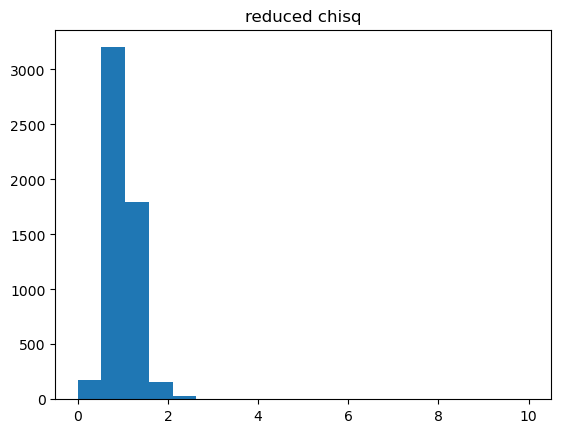

In [38]:
idx = result_df.ndof > 0
result_df = result_df[idx]
plt.hist(result_df[idx].chisq/result_df[idx].ndof,bins=np.linspace(0,10,20))
plt.title('reduced chisq')

Text(0.5, 1.0, 'x1-sim_x1')

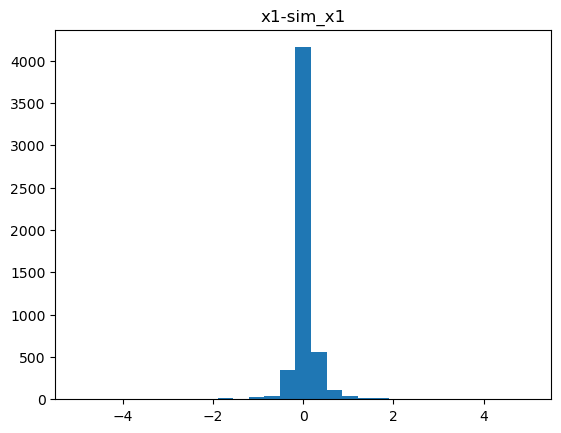

In [39]:
x1 = result_df['x1']
sim_x1 = [lc_to_fit.loc[i]['params']['source.x1'] for i in result_df.index]
plt.hist(x1-sim_x1,bins=np.linspace(-5,5,30))
plt.title('x1-sim_x1')

Text(0.5, 1.0, 'c-sim_c')

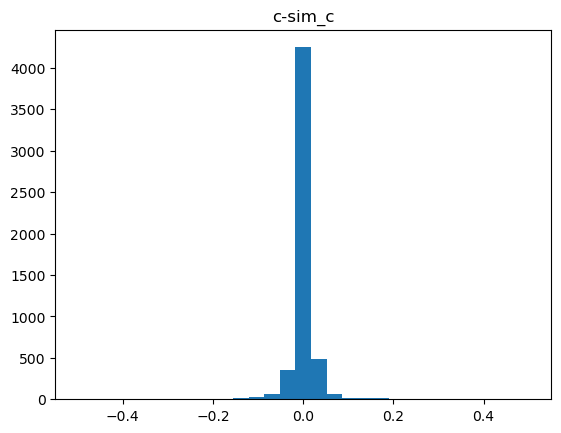

In [40]:
c = result_df['c']
sim_c = [lc_to_fit.loc[i]['params']['source.c'] for i in result_df.index]
plt.hist(c-sim_c,bins=np.linspace(-0.5,0.5,30))
plt.title('c-sim_c')

Text(0.5, 1.0, 'x0-sim_x0')

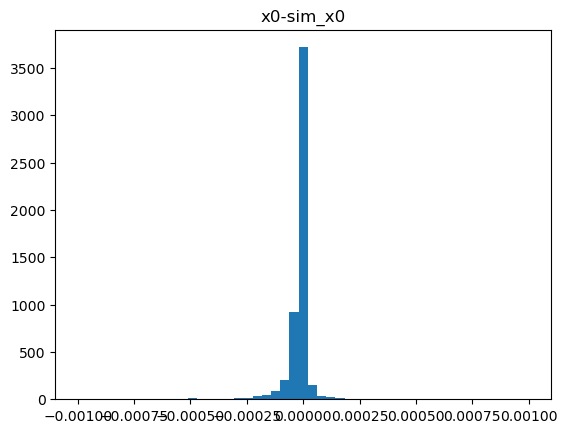

In [41]:
x0 = result_df['x0']
sim_x0 = [lc_to_fit.loc[i]['params']['source.x0'] for i in result_df.index]
plt.hist(x0-sim_x0,bins=np.linspace(-1.e-3,1.e-3))
plt.title('x0-sim_x0')

Text(0.5, 1.0, 'log(x0)-log(sim_x0)')

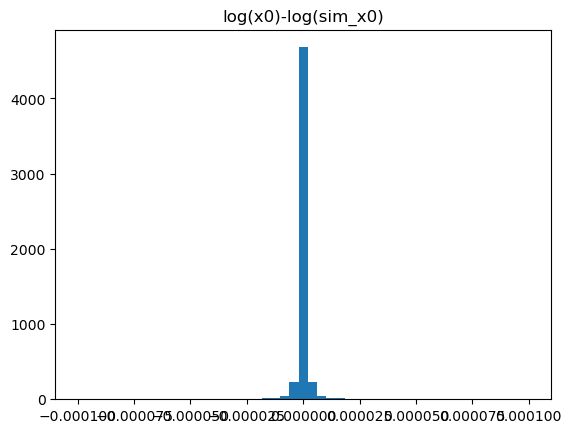

In [42]:
x0 = result_df['t0']
sim_x0 = [lc_to_fit.loc[i]['params']['source.t0'] for i in result_df.index]
plt.hist(np.log10(x0/sim_x0),bins=np.linspace(-1.e-4,1e-4))
plt.title('log(x0)-log(sim_x0)')

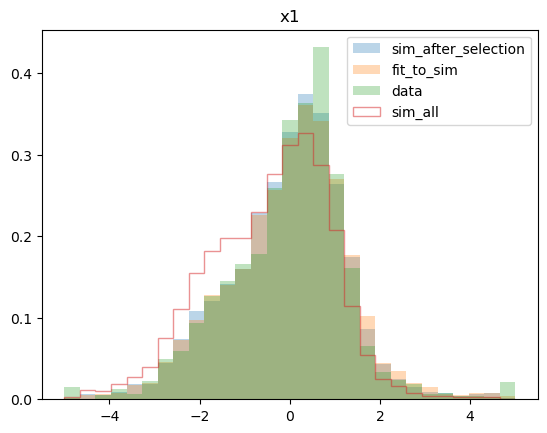

In [43]:
bins=np.linspace(-5,5,30)
plt.hist(sim_x1,bins=bins,alpha=0.3,density=True,label='sim_after_selection')
plt.hist(x1,bins=bins,alpha=0.3,density=True,label='fit_to_sim')
plt.hist(data.x1,bins=bins,alpha=0.3,density=True,label='data')
plt.hist(sim_all_x1,bins=bins,alpha=0.5,density=True,label='sim_all',histtype='step')
plt.legend()
plt.title('x1')
plt.savefig('paper_figs/x1_distr.png')

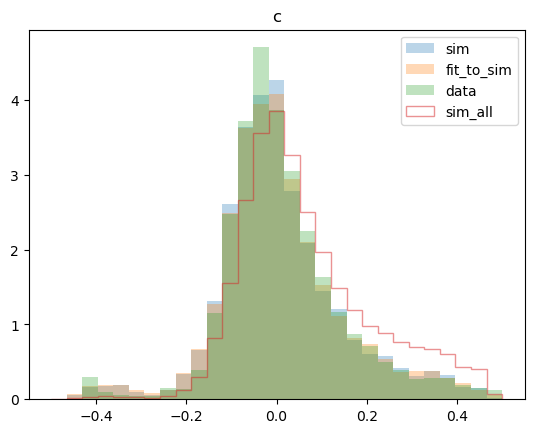

In [44]:
bins=np.linspace(-0.5,0.5,30)
plt.hist(sim_c,bins=bins,alpha=0.3,density=True,label='sim')
plt.hist(c,bins=bins,alpha=0.3,density=True,label='fit_to_sim')
plt.hist(data.c,bins=bins,alpha=0.3,density=True,label='data')
plt.hist(sim_all_c,bins=bins,alpha=0.5,density=True,label='sim_all',histtype='step')
plt.legend()
plt.title('c')
plt.savefig('paper_figs/c_distr.png')

Text(0.5, 1.0, 'host mass')

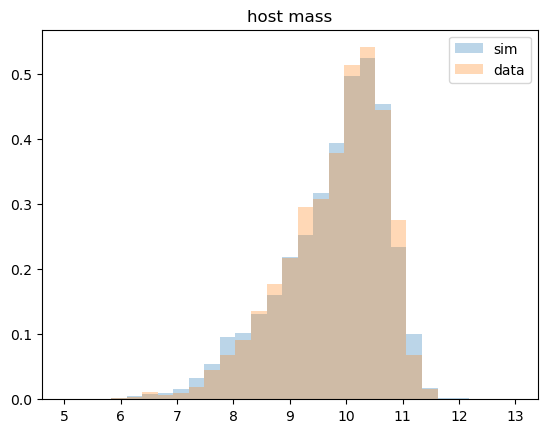

In [45]:
hostmass = [lc_to_fit.loc[i]['params']['host.hostmass'] for i in result_df.index]
bins = np.linspace(5,13,30)
plt.hist(hostmass,bins=bins,alpha=0.3,density=True,label='sim')
plt.hist(data.mass,bins=bins,alpha=0.3,density=True,label='data')
plt.legend()
plt.title('host mass')

4803
3163


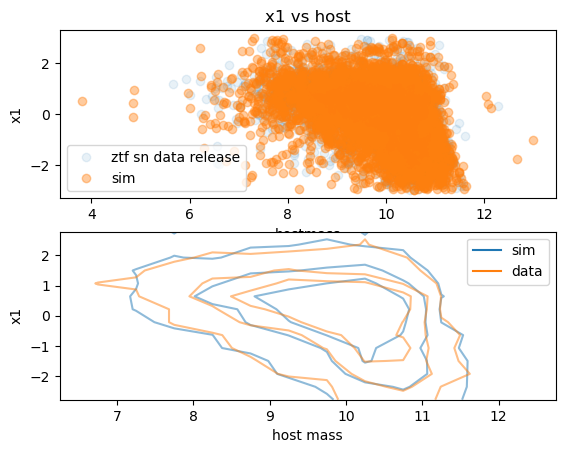

In [48]:
idx = np.array((x1 > -3.) & (x1 < 3.) & (c > -0.3) & (c < 0.3))
data_idx = np.array((data.x1 > -3.) & (data.x1 < 3.) & (data.c > -0.3) & (data.c < 0.3))
print(np.sum(idx))
print(np.sum(data_idx))

fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(data[data_idx].mass,data[data_idx].x1,'o',label='ztf sn data release',alpha=0.1)
plt.plot(np.array(hostmass)[idx],np.array(x1)[idx],'o',label='sim',alpha=0.4)
plt.xlabel('hostmass')
plt.ylabel('x1')
plt.legend()
plt.title('x1 vs host')
# plt.show()

plt.subplot(2,1,2)
bins_x1 = np.linspace(-3,3,15)
bins_hostmass = np.linspace(6,13,15)

data_plot = data[data_idx]
sim_host = np.array(hostmass)[idx]
sim_x1 = np.array(x1)[idx]

binwidth_host = bins_hostmass[1]-bins_hostmass[0]
binwidth_x1 = bins_x1[1]-bins_x1[0]

sim_count,sim_x_edges,sim_y_edges, _ = stats.binned_statistic_2d(sim_host,sim_x1,
                                             np.ones(len(sim_host)),
                                             statistic='sum',bins=[bins_hostmass,bins_x1])
data_count,data_x_edges,data_y_edges,_ = stats.binned_statistic_2d(data_plot.mass,data_plot.x1,
                                         np.ones(len(data_plot.mass)),
                                         statistic='sum',bins=[bins_hostmass,bins_x1])
sim_x = 0.5* (sim_x_edges[:-1]+sim_x_edges[1:])
sim_y = 0.5* (sim_y_edges[:-1]+sim_y_edges[1:])
data_x = 0.5* (data_x_edges[:-1]+data_x_edges[1:])
data_y = 0.5* (data_y_edges[:-1]+data_y_edges[1:])
sim_x_plot,sim_y_plot = np.meshgrid(sim_x, sim_y)
data_x_plot,data_y_plot = np.meshgrid(data_x, data_y)
CS = plt.contour(sim_x_plot.T,sim_y_plot.T,sim_count/np.sum(sim_count)/binwidth_host/binwidth_x1,alpha=0.5,levels=[0.01,0.05,0.1],colors='C0')
CS = plt.contour(data_x_plot.T,data_y_plot.T,data_count/np.sum(data_count)/binwidth_host/binwidth_x1,alpha=0.5,levels=[0.01,0.05,0.1],colors='C1')
proxies = [Line2D([],[],color=c) for c in ['C0','C1']]
plt.legend(proxies,['sim', 'data'])
plt.xlabel('host mass')
plt.ylabel('x1')
plt.show()
fig.savefig('paper_figs/host_x1.png')

Effects maybe simulated
ZTF Photometry "pocket effect" (Fig 2 of ZTF DR2 Overview paper https://arxiv.org/pdf/2409.04346)
<img src="figs/pocket_effect.png" width="400" height="300">
